In [145]:
import numpy as np
import matplotlib.pyplot as plt
from Functions import *
from collections import namedtuple
from scipy.interpolate import CubicSpline

In [146]:
def n_Si3N4(wavl_um):
    return (1+3.0249/(1-(0.1353406/wavl_um)**2)+
            40314/(1-(1239.842/wavl_um)**2))**.5
def n_SiO2(wavl_um):
    return (1+0.6961663/(1-(0.0684043/wavl_um)**2)+
            0.4079426/(1-(0.1162414/wavl_um)**2)+
            0.8974794/(1-(9.896161/wavl_um)**2))**.5

In [147]:
def Load_n(filename):
    info_file_name = "../data/" + filename
    n_list = []
    # dtype = [('modeidx', 'i2'), ('n', str),
    #          ('ng', str), ('loss', 'f8'), ('polarization','f8')]
    # data_read = np.loadtxt(info_file_name, delimiter=',', dtype=dtype,skiprows=1)
    with open(info_file_name,'r') as f:
        data_read = f.readlines()
        for line in data_read[1:]:
            wavl = float(line.split(',')[0].replace(" ","").replace("\n",""))
            n = float(line.split(',')[1].replace(" ","").replace("\n",""))
            n_list.append([wavl,n])
    n_list = np.array(n_list)
    return n_list

In [148]:
def Interpolation(x,y,x_intp,num_of_pts=100):
    cs = CubicSpline(x, y, bc_type='natural')  # bc_type 可选 'natural', 'clamped', 'periodic' 等
    y_intp = cs(x_intp)
    return y_intp


In [149]:
# Load kappa under different wavls of two coupled WGs width 2.8um
def Load_kappa_data():
    c = 3*10**8
    Kappa_arr = []
    with open ("./results/straight_WG_Kappa.txt",'r') as f:
        read_data = f.readlines()
        for line in read_data[1:]:
            line_strip = line.strip()
            wavl = float(line_strip.split(",")[0])
            freq = c/wavl * 1e9
            K_12 = str2complex(line_strip.split(",")[1])
            K_21 = str2complex(line_strip.split(",")[2])
            Kappa = (K_12+K_21)/2
            Kappa = np.real(Kappa)
            Kappa_arr.append([freq,Kappa])
        Kappa_arr = np.array(Kappa_arr)
    return Kappa_arr

In [150]:
# g : dict of coupling strength
def Reson_freq(m,D1,g,L,epsilon):
    return D1/(2*np.pi)*np.arccos(np.cos(g*L)*np.cos(2*np.pi * epsilon *m))

def FSR_func(m,D_ave,g,L,epsilon):
    return epsilon * D_ave/(2*np.pi)* np.cos(g*L)*np.sin(2*np.pi * epsilon *m) /        \
            (1-np.cos(g*L)**2 * np.cos(2*np.pi * epsilon *m)**2)**0.5

def Dispersion(m,D_ave,g,L,epsilon):
    return D_ave *(2*np.pi)* epsilon**2 *np.cos(g*L) *np.sin(g*L)**2 * np.cos(2*np.pi*epsilon*m) / \
            (1-np.cos(g*L)**2 * np.cos(2*np.pi * epsilon *m)**2)**1.5

In [151]:
def find_resonance(m,freq_arr,neff_arr,L):
    # freq_arr  unit:THz
    func_arr = freq_arr*1e12 * neff_arr - np.ones(np.shape(freq_arr)) * m * c / L
    zero_arr,zero_idx_arr = find_zero(freq_arr,func_arr)
    assert len(zero_arr) == 1
    return zero_arr[0],zero_idx_arr[0]

In [152]:
# returns the anomalous dispersion range around 1550nm of 2D parallel coupled rings (unit: nm)
def AD_range_func(m_arr,D_arr,M,FSR):
    zero_list,zero_idx_list = find_zero(m_arr_intp, D_arr)
    zero_list               = np.array(zero_list)
    zero_list_m_0           = zero_list[np.where(np.abs(zero_list) < M)]      # zeros around mode numer m = 0
    if len(zero_list_m_0) > 0:
        return (np.max(zero_list_m_0) - np.min(zero_list_m_0))*FSR * 1e-9 /100 * 0.8
    else:
        return 0

constants

In [153]:
c  = 3*1e8
mm = 1e-3
n  = 1.99

How the effective refractive index change at different wavls

In [154]:
n_eff_arr   = []
n_g_arr     = []
foldername  = "Straight_WG_width_2_8um"
filename    = "neff_L_inner_2_8_1500_1600.txt"
neff_arr    = Load_n(filename)
filename    = "ng_L_inner_2_8_1500_1600.txt"
ng_arr      = Load_n(filename)

num_of_pts  = 1000
wavl_arr    = neff_arr[:,0]                   #unit: um
wavl_arr_intp = np.linspace(np.min(wavl_arr),np.max(wavl_arr),num_of_pts)
neff_intp   = Interpolation(wavl_arr, neff_arr[:,1], wavl_arr_intp, num_of_pts=num_of_pts)
ng_intp     = Interpolation(wavl_arr, ng_arr[:,1], wavl_arr_intp, num_of_pts=num_of_pts)
ng_1550     = ng_intp[np.argmin(np.abs(wavl_arr_intp-1.55))]
neff_1550   = neff_intp[np.argmin(np.abs(wavl_arr_intp-1.55))]
freq_1550   = c/1550*1e9                        #unit:Hz

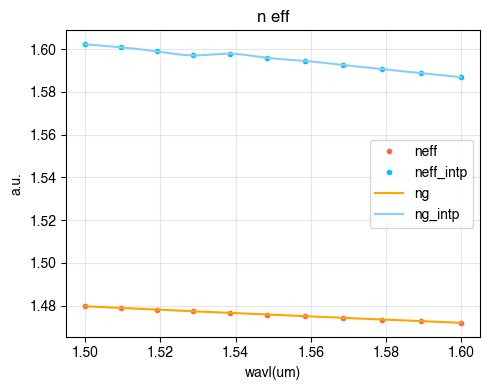

In [155]:
data_arr =  (   np.c_[wavl_arr, neff_arr[:,1], ng_arr[:,1]],
                np.c_[wavl_arr_intp, neff_intp, ng_intp],)
Plot_curve(data_arr,Y_legends=["neff","neff_intp","ng","ng_intp"],
                X_label="wavl(um)",Y_label="a.u.",
                xticks =[], xtickslabel=[],
                title = "n eff",
                figsize =(5,4),
                marker_list=[".",".","",""]*2,linestyle_list=["","","-","-"]*2,
                colors_list=['tomato','deepskyblue','orange','lightskyblue']*2,
                ylim = (),dpi=400)


In [156]:
# wavl_arr_intp_m = wavl_arr_intp * 1e-6
# Beta_1_intp     = First_derivative_central_diff(neff_intp, wavl_arr_intp_m)
# Beta_2_intp     = wavl_arr_intp_m[2:-2]**3 / (2*np.pi*c**2) * First_derivative_central_diff(Beta_1_intp,
#                                                                                 wavl_arr_intp_m[1:-1])
# D_2             = -c*D_ave**2 * Beta_2_intp / ng_intp[2:-2]
# plt.plot(wavl_arr_intp_m[2:-2],D_2/(2*np.pi))

Parameters of the vernier resonators

In [157]:
L1      = c/(ng_1550**2 * 20*1e9)
L2      = L1 * 1.01
D1      = c/(ng_1550**2 * L1) *2* np.pi
D2      = c/(ng_1550**2 * L2) *2* np.pi
D_ave   = c/(ng_1550**2 * (L1+L2)/2) *2 *np.pi
# D_ave = D1 * 0.99
epsilon = (L2-L1)/(L1+L2)

FSR = (D1-D2)/(2*epsilon)
M = 1/(2*epsilon)
FSR/1e9/(2*np.pi)
D_ave/(2*np.pi*1e9)

np.float64(19.900497512437813)

In [158]:
Max_M_idx   = 2
num_of_pts  = 1000

Find Kappa at different wavls

In [159]:
Kappa_arr       = Load_kappa_data()
Kappa_arr       = np.flip(Kappa_arr,axis=0)
freq_arr        = Kappa_arr[:,0]
freq_arr

array([1.85185185e+14, 1.86335404e+14, 1.87500000e+14, 1.88679245e+14,
       1.89873418e+14, 1.91082803e+14, 1.92307692e+14, 1.93548387e+14,
       1.94805195e+14, 1.96078431e+14, 1.97368421e+14, 1.98675497e+14,
       2.00000000e+14, 2.01342282e+14, 2.02702703e+14])

In [160]:
m_arr_intp      = np.linspace(-Max_M_idx*M, Max_M_idx*M, num_of_pts)
freq_arr_intp   = freq_1550 + m_arr_intp * D_ave/(2*np.pi)
g_arr_intp      = Interpolation(freq_arr,Kappa_arr[:,1],freq_arr_intp)

np.c_[m_arr_intp,freq_arr_intp,g_arr_intp]

array([[-2.01000000e+02,  1.89548387e+14,  8.08983623e+02],
       [-2.00597598e+02,  1.89556395e+14,  8.08692718e+02],
       [-2.00195195e+02,  1.89564403e+14,  8.08401903e+02],
       ...,
       [ 2.00195195e+02,  1.97532371e+14,  5.60170892e+02],
       [ 2.00597598e+02,  1.97540379e+14,  5.59959101e+02],
       [ 2.01000000e+02,  1.97548387e+14,  5.59747380e+02]],
      shape=(1000, 3))

In [161]:
def Mode_nonconserved_coupling(Max_M_idx,M,
                               plot_coupled_curves=True,
                               coupled_data_arr=[],coupled_data_label_arr=[],
                               num_of_pts=100,ylim=()):
    m_arr = np.linspace(-Max_M_idx*M, Max_M_idx*M, num_of_pts).reshape(-1,1)
    M0 = 0
    Y_legends = []
    Y_data = np.array(D1 * (m_arr - M0))
    Y_legends.append(r"Resonator1 $\omega = \omega_0$+$(D_1-D_{ave})$(m-$M_0$)")
    for m in range(1,Max_M_idx):
        Y = D1 * (m_arr - M0) + m*FSR
        Y_data = np.c_[Y_data,Y]
        Y_legends.append(r"Resonator1 $\omega$ = $\omega_0$+$(D_1-D_{ave})$(m-$M_0$)$\pm$"+str(m)+r"$D_{ave}$")
        Y = D1 * (m_arr - M0) - m*FSR
        Y_data = np.c_[Y_data,Y]
        Y_legends.append("")

    Y = D2 * (m_arr - M0)
    Y_data = np.c_[Y_data,Y]
    Y_legends.append(r"Resonator2 $\omega = \omega_0$+$(D_2-D_{ave})$(m-$M_0$)")
    for m in range(1,Max_M_idx):
        Y = D2 * (m_arr - M0) +  m*FSR
        Y_data = np.c_[Y_data,Y]
        Y_legends.append(r"Resonator2 $\omega$ = $\omega_0$+$(D_2-D_{ave})$(m-$M_0$)$\pm$"+str(m)+r"$D_{ave}$")
        Y = D2 * (m_arr - M0) -  m*FSR
        Y_data = np.c_[Y_data,Y]
        Y_legends.append("")
    Y_data = Y_data - D_ave * (m_arr - M0)

    if plot_coupled_curves:
        Y_data = np.c_[Y_data,coupled_data_arr]
        Y_legends = Y_legends + coupled_data_label_arr

    xticks       = np.arange(-Max_M_idx,Max_M_idx+1)
    xtickslabels = [("$M_0$+" if xtick>0 else "$M_0$") + str(xtick) + "M"  for xtick in xticks]
    xtickslabels[int(len(xtickslabels)/2)] = "$M_0$"
    xticks       = np.arange(-Max_M_idx,Max_M_idx+1)*M
    # xtickslabels = np.c_[xtickslabels,""]

    data_arr = (np.c_[m_arr,Y_data/1e9/(2*np.pi)],)
    linestyle_name_list = ["dashed","dotted"]*3
    linestyle_list      = ["-"]
    for i in range(Max_M_idx-1):
        for j in range(2):
            linestyle_list.append(linestyle_name_list[i])
    linestyle_list = linestyle_list + linestyle_list
    linestyle_list = linestyle_list + ["-"]*30
    Plot_curve(data_arr,
                Y_legends=Y_legends,
                X_label='mode number m',Y_label=r"Frequency $\omega$/(2$\pi$) (GHz)",
                xticks=xticks, xtickslabel=xtickslabels,
                title = "Mode number non-conservation coupling",
                marker_list=[""]*30,
                linestyle_list=linestyle_list,
                colors_list = ['tab:blue']*(Max_M_idx*2-1)+
                ['tab:red']*(Max_M_idx*2-1)+['tab:orange']*2+['tab:green']*2+['black']*30,
                ylim = ylim, bbox_legend=(1.05,0.8))


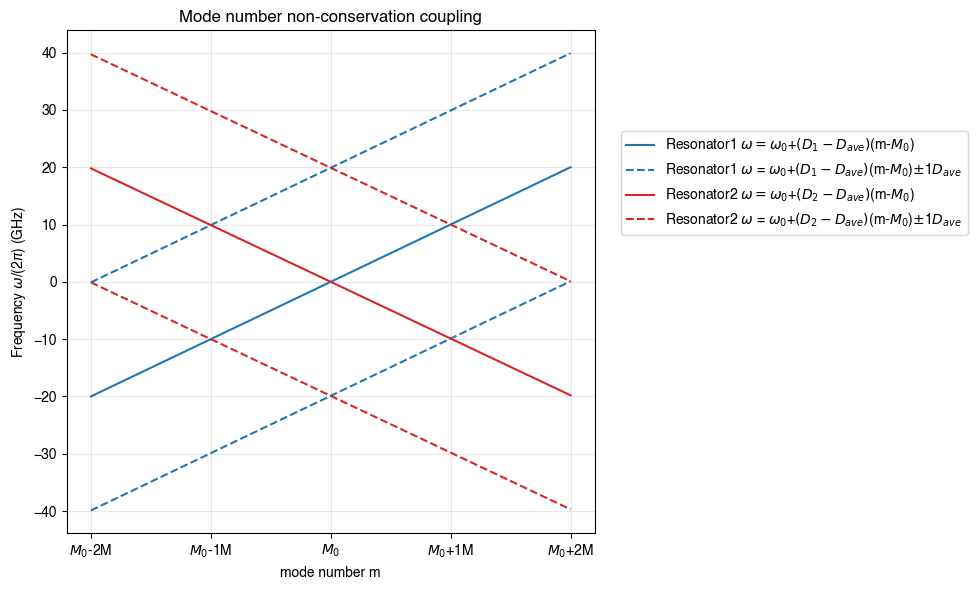

In [162]:
Mode_nonconserved_coupling(Max_M_idx,M,plot_coupled_curves=False,
                           coupled_data_arr=data_arr,
                           coupled_data_label_arr=[],
                           num_of_pts=num_of_pts)

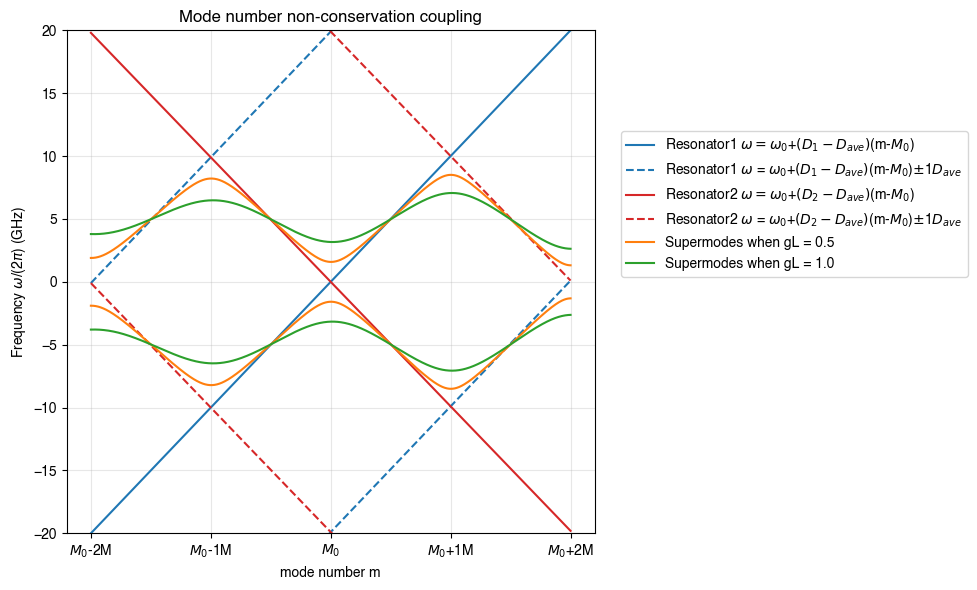

In [163]:
g0      = g_arr_intp[np.argmin(np.abs(0 - m_arr_intp))]
L1      = 0.5 / g0
Y_p_0_3 = Reson_freq(m_arr_intp,D_ave,g_arr_intp,L1,epsilon)
Y_m_0_3 = -Reson_freq(m_arr_intp,D_ave,g_arr_intp,L1,epsilon)
L2      = 1/g0
Y_p_1   = Reson_freq(m_arr_intp,D_ave,g_arr_intp,L2,epsilon)
Y_m_1   = -Reson_freq(m_arr_intp,D_ave,g_arr_intp,L2,epsilon)
data_arr = np.c_[Y_p_0_3,Y_m_0_3,Y_p_1,Y_m_1]
data_label_arr = ["","Supermodes when gL = "+"{:.1f}".format(g0*L1)
                  ,"","Supermodes when gL = "+"{:.1f}".format(g0*L2)]
Mode_nonconserved_coupling(Max_M_idx,M,plot_coupled_curves=True,
                           coupled_data_arr=data_arr,
                           coupled_data_label_arr=data_label_arr,
                           num_of_pts=num_of_pts,ylim=(-20,20))


In [164]:
D_iso   = -668                                # unit: ps/nm/km
n_g     = 1.59367
beta_2  = -1550**2/(2*np.pi*c) * D_iso *1e-9  # unit: ps^2/nm
D_2     = -c* (D_ave*1e-12)**2* beta_2 / n_g  # unit: 2pi * GHz
D_2o    = D_2*1e9                            # unit: Hz
D_2o    = -284 *1e3 * 2*np.pi
D_2o

-1784424.6272390024

In [165]:
L1              = 0.3/g0
D_small_couple  = Dispersion(m_arr_intp,D_ave,g_arr_intp,L1,epsilon)
# Y_small_couple  = Dispersion(m_arr_intp,D_ave,1,L1,epsilon)
L2              = 1/g0
D_large_couple  = Dispersion(m_arr_intp,D_ave,g_arr_intp,L2,epsilon)
# Y_large_couple  = Dispersion(m_arr_intp,D_ave,1,L2,epsilon)
D_iso           = D_2o * np.ones(np.shape(m_arr_intp))

AD_range = AD_range_func(m_arr_intp,D_large_couple+D_iso,
         M = M, FSR = D_ave/(2*np.pi))
AD_range


np.float64(13.581197050169042)

(np.float64(-12475.98103923963), np.float64(13049.959215054354))

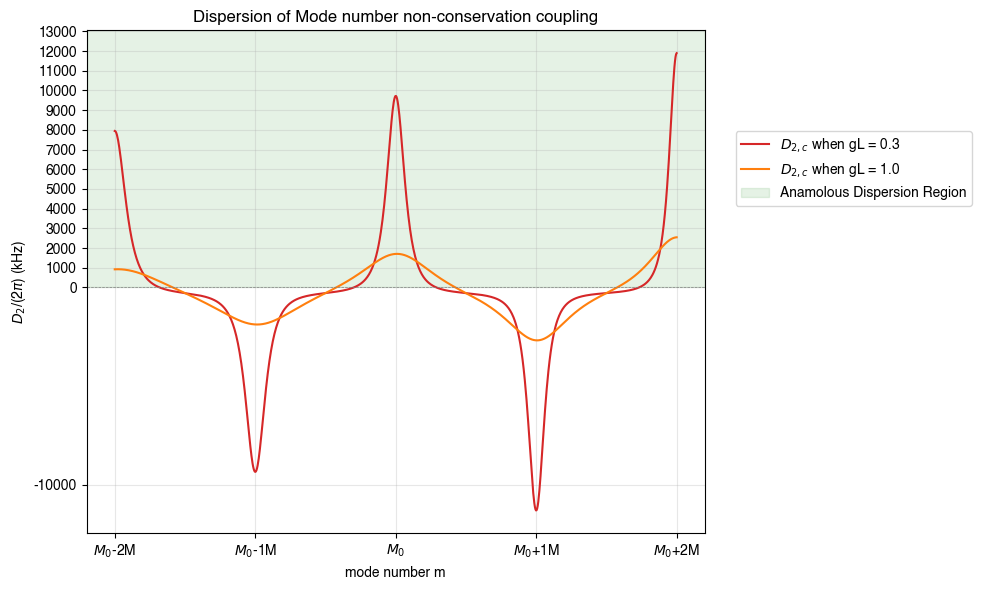

In [166]:
# data_arr        = np.c_[Y_small_couple,Y_large_couple,Y_iso]
data_arr        = np.c_[D_small_couple+D_iso,D_large_couple+D_iso]
data_label_arr = [r"$D_{2,c}$ when gL = "+"{:.1f}".format(L1*g0),
                  r"$D_{2,c}$ when gL = "+"{:.1f}".format(L2*g0),
                  r"$D_{2,o}$ (dispersion of uncoupled resonator)"]

data_arr     = (np.c_[m_arr_intp,data_arr/1e3/(2*np.pi)],)
linestyle_list = ["-"]*10
xticks       = np.arange(-Max_M_idx,Max_M_idx+1)
xtickslabels = [("$M_0$+" if xtick>0 else "$M_0$") + str(xtick) + "M"  for xtick in xticks]
xtickslabels[int(len(xtickslabels)/2)] = "$M_0$"
xticks       = np.arange(-Max_M_idx,Max_M_idx+1)*M
yticks       = ticks_arr(data_arr)
Plot_curve(data_arr,
            Y_legends=data_label_arr,
            X_label='mode number m',Y_label=r"$D_2$/(2$\pi$) (kHz)",
            title = "Dispersion of Mode number non-conservation coupling",
            marker_list=[""]*15,
            linestyle_list=linestyle_list,
            colors_list = ['tab:red']+['tab:orange']+['tab:blue']+['tab:green']*2+['black']*10,
            xticks=xticks, xtickslabel=xtickslabels,
            yticks = yticks,
            ylim = (), fill_color = True,
            bbox_legend=(1.05,0.8))
plt.ylim()


In [167]:
gL_product_arr  = np.arange(0.1,1.6,0.0001)
L_arr           = gL_product_arr  / g0
AD_range_arr = []
for L in L_arr:
    D_coupled  = Dispersion(m_arr_intp,D_ave,g_arr_intp,L,epsilon)
    AD_range_res = AD_range_func(m_arr_intp, D_coupled + D_iso,
                                M = M, FSR = D_ave/(2*np.pi))
    AD_range_arr.append(AD_range_res)
AD_range_arr    = np.array(AD_range_arr)

max_AD_range         = np.max(AD_range_arr)
max_idx              = np.argmax(AD_range_arr)
max_AD_range_arr_y   = np.ones(np.shape(gL_product_arr))[:max_idx] * max_AD_range
max_AD_range_arr_x   = gL_product_arr[:max_idx]
max_idx_range_arr_y  = np.linspace(0,max_AD_range,1000)
max_idx_range_arr_x  = np.ones(np.shape(max_idx_range_arr_y))*gL_product_arr[max_idx]

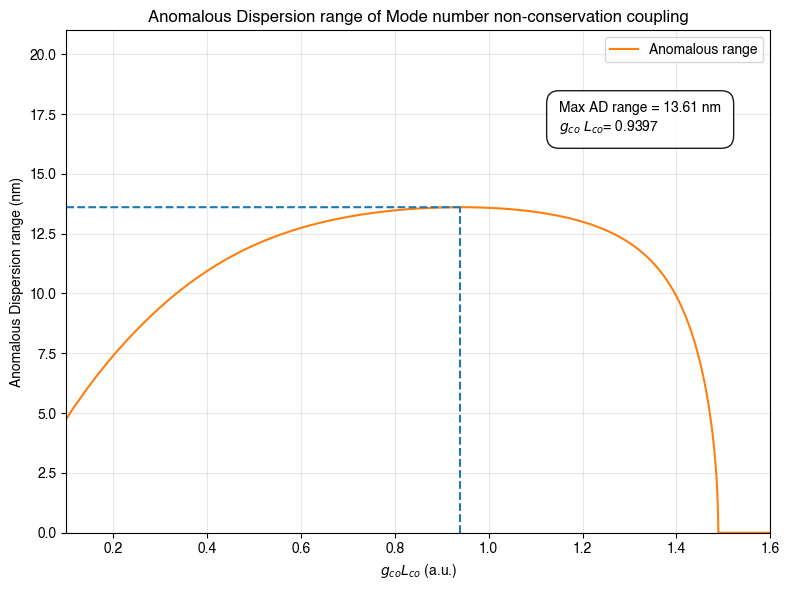

In [168]:
# data_arr        = np.c_[Y_small_couple,Y_large_couple,Y_iso]
data_arr        = (np.c_[gL_product_arr, AD_range_arr],
                   np.c_[max_AD_range_arr_x,max_AD_range_arr_y],
                   np.c_[max_idx_range_arr_x,max_idx_range_arr_y],)
data_label_arr = [r"Anomalous range","",""]*3

linestyle_list  = ["-","--","--"]*3
# xticks          = np.arange(-Max_M_idx,Max_M_idx+1)
# xtickslabels    = ["{:.2f}".format((freq_1550 + D_ave/(2*np.pi) * xtick)/1e12) for xtick in xticks]
text            = "Max AD range = {:.2f} nm\n".format(max_AD_range) +\
                r'$g_{co}$ $L_{co}$' +'= {:.4f}'.format(gL_product_arr[max_idx])
Plot_curve(data_arr,
            Y_legends=data_label_arr,
            X_label=r'$g_{co} L_{co}$ (a.u.)',Y_label=r"Anomalous Dispersion range (nm)",
            title = "Anomalous Dispersion range of Mode number non-conservation coupling",
            figsize = (8,6),
            marker_list=[""]*15,
            linestyle_list=linestyle_list,
            colors_list = ['tab:orange']+['tab:blue']*2+['tab:green']*2+['black']*10,
            # xticks=xticks, xtickslabel=xticks,
            # yticks = yticks,
            xlim = (0.1,1.6), ylim = (0,21), fill_color = False,
            text = text,loc_text = (0.7,0.8))

In [169]:
# Best coupling length Lco
0.7938/g0 * 1e3     #unit: mm

np.float64(1.1768542891975227)

In [170]:
# Circumference of the racetrack
3*10**8 / (1.6 * D_ave/(2*np.pi)) * 1e3     #unit: mm

np.float64(9.421875)

<>:15: SyntaxWarning: invalid escape sequence '\l'
<>:15: SyntaxWarning: invalid escape sequence '\l'
/var/folders/ch/7r5m10cd1x18pgpw08_ksg300000gn/T/ipykernel_58460/1925008017.py:15: SyntaxWarning: invalid escape sequence '\l'
  text            = r"$g_{co}$" + r" = {:.2f} ".format(g0)+"$m^{-1}$ when $\lambda$ = 1550 nm"


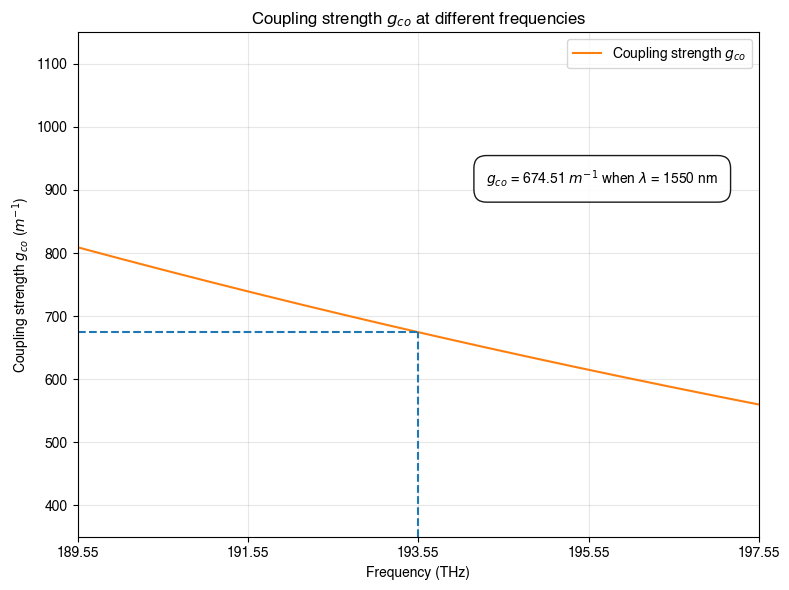

In [171]:
idx             = np.argmin(np.abs(m_arr_intp))
horizontal_y    = np.ones(np.shape(m_arr_intp))[:idx] * g0
horizontal_x    = m_arr_intp[:idx]
vertical_y      = np.linspace(350,g0,1000)
vertical_x      = np.ones(np.shape(vertical_y))* 0

data_arr        = (np.c_[m_arr_intp, g_arr_intp],
                   np.c_[vertical_x,vertical_y],
                   np.c_[horizontal_x,horizontal_y])
data_label_arr  = [r"Coupling strength $g_{co}$","",""]*3

linestyle_list  = ["-","--","--"]*3
xticks          = np.arange(-Max_M_idx,Max_M_idx+1)*M
xtickslabels    = ["{:.2f}".format((freq_1550 + D_ave/(2*np.pi) * xtick)/1e12) for xtick in xticks]
text            = r"$g_{co}$" + r" = {:.2f} ".format(g0)+"$m^{-1}$ when $\lambda$ = 1550 nm"
Plot_curve(data_arr,
            Y_legends=data_label_arr,
            X_label=r'Frequency (THz)',Y_label=r"Coupling strength $g_{co}$ ($m^{-1}$)",
            title = r"Coupling strength $g_{co}$ at different frequencies",
            figsize = (8,6),
            marker_list=[""]*15,
            linestyle_list=linestyle_list,
            colors_list = ['tab:orange']+['tab:blue']*2+['tab:green']*2+['black']*10,
            xticks=xticks, xtickslabel=xtickslabels,
            # yticks = yticks,
            xlim = (np.min(m_arr_intp),np.max(m_arr_intp)),
            ylim = (350,1150),
            text = text,loc_text = (0.6,0.7),
            fill_color = False)

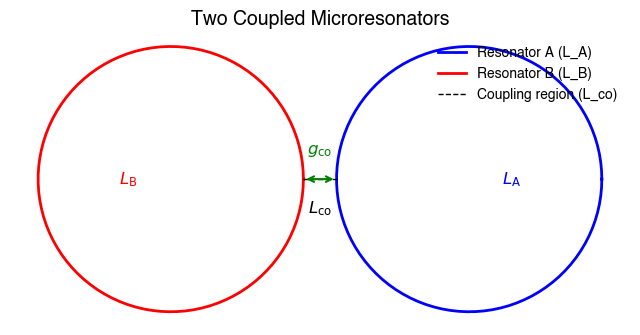

In [172]:
import matplotlib.pyplot as plt
import numpy as np

# 创建画布和坐标轴
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_aspect('equal')
ax.axis('off')  # 隐藏坐标轴

# 定义微环参数
R1, R2 = 2.0, 2.0  # 两个环的半径
d = 0.5             # 耦合区域的间距
L_co = 1.0          # 耦合区域长度（近似）

# 绘制两个微环（跑道形结构）
theta = np.linspace(0, 2*np.pi, 100)

# 环A（右环）
x_A = R1 * np.cos(theta) + R1 + d/2
y_A = R1 * np.sin(theta)
ax.plot(x_A, y_A, color='blue', lw=2, label='Resonator A (L_A)')

# 环B（左环）
x_B = R2 * np.cos(theta) - R2 - d/2
y_B = R2 * np.sin(theta)
ax.plot(x_B, y_B, color='red', lw=2, label='Resonator B (L_B)')

# 绘制耦合区域（用虚线表示）
coupling_x = np.linspace(-d/2, d/2, 50)
coupling_y = np.zeros_like(coupling_x)
ax.plot(coupling_x, coupling_y, '--', color='black', lw=1, label='Coupling region (L_co)')

# 添加标注
ax.annotate('', xy=(d/2, 0), xytext=(-d/2, 0),
            arrowprops=dict(arrowstyle='<->', color='green', lw=1.5))
ax.text(0, 0.3, r'$g_{\mathrm{co}}$', ha='center', va='bottom', fontsize=12, color='green')
ax.text(R1 + d/2 + 0.5, 0, r'$L_{\mathrm{A}}$', ha='left', va='center', fontsize=12, color='blue')
ax.text(-R2 - d/2 - 0.5, 0, r'$L_{\mathrm{B}}$', ha='right', va='center', fontsize=12, color='red')
ax.text(0, -0.3, r'$L_{\mathrm{co}}$', ha='center', va='top', fontsize=12, color='black')

# 添加图例和标题
ax.legend(loc='upper right', frameon=False)
plt.title('Two Coupled Microresonators', fontsize=14)

# 显示图形
plt.show()